In [173]:
import uproot	
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import awkward as ak
from scipy.optimize import curve_fit
%matplotlib inline

In [174]:
file = uproot.open("tracking_losses_ntuple_Bd2KstEE.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1")
#file = uproot.open(
#    "tracking_losses_ntuple_B_default.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1"
#)

# selektiere nur elektronen von B->K*ee
allcolumns = file.arrays()
found = allcolumns[
    (allcolumns.isElectron) & (~allcolumns.lost) & (allcolumns.fromB)
]  # B: 9056
lost = allcolumns[
    (allcolumns.isElectron) & (allcolumns.lost) & (allcolumns.fromB)
]  # B: 1466

electrons = allcolumns[(allcolumns.isElectron) & (allcolumns.fromB)]

print(ak.num(found, axis=0), ak.num(lost, axis=0))
print(ak.num(electrons,axis=0))
# ak.count(found, axis=None)

10923 2390
13313


In [175]:
#electrons[0]

In [176]:
lost_e = electrons["lost"]
e = electrons["energy"]
brem_pe = electrons["brem_photons_pe"]
brem_z = electrons["brem_vtx_z"]
brem_x = electrons["brem_vtx_x"]
length = electrons["brem_vtx_z_length"]



brem = ak.ArrayBuilder()

for itr in range(ak.num(electrons, axis=0)):
    brem.begin_record()
    brem.field("lost").boolean(lost_e[itr])
    # [:,"energy"] energy
    brem.field("energy").append(e[itr])
    # [:,"photon_length"] number of vertices
    brem.field("photon_length").integer(length[itr])
    # [:,"brem_photons_pe",:] photon energy
    brem.field("brem_photons_pe").append(brem_pe[itr])
    # [:,"brem_vtx_z",:] brem vtx z
    brem.field("brem_vtx_x").append(brem_x[itr])
    brem.field("brem_vtx_z").append(brem_z[itr])
    brem.end_record()

brem = ak.Array(brem)

In [177]:
photon_cut = 0
photon_cut_ratio = 0.2

cut_brem = ak.ArrayBuilder()

for itr in range(ak.num(brem, axis=0)):
    cut_brem.begin_record()
    cut_brem.field("lost").boolean(brem[itr, "lost"])
    cut_brem.field("energy").real(brem[itr, "energy"])

    ph_length = brem[itr, "photon_length"]
    
    tmp_energy = brem[itr, "energy"]

    cut_brem.field("brem_photons_pe")
    cut_brem.begin_list()
    for jentry in range(brem[itr, "photon_length"]):
        if (
            brem[itr, "brem_vtx_z", jentry] > 3000
            or brem[itr, "brem_photons_pe", jentry] < photon_cut
            or brem[itr, "brem_photons_pe", jentry] < photon_cut_ratio * tmp_energy
        ):
            ph_length -= 1
            continue
        else:
            cut_brem.real(brem[itr, "brem_photons_pe", jentry])
            tmp_energy -= brem[itr, "brem_photons_pe", jentry]
    cut_brem.end_list()

    tmp_energy = brem[itr, "energy"]

    cut_brem.field("brem_vtx_x")
    cut_brem.begin_list()
    for jentry in range(brem[itr, "photon_length"]):
        if (
            brem[itr, "brem_vtx_z", jentry] > 3000
            or brem[itr, "brem_photons_pe", jentry] < photon_cut
            or brem[itr, "brem_photons_pe", jentry] < photon_cut_ratio * tmp_energy
        ):
            continue
        else:
            cut_brem.real(brem[itr, "brem_vtx_x", jentry])
            tmp_energy -= brem[itr, "brem_photons_pe", jentry]
    cut_brem.end_list()

    tmp_energy = brem[itr, "energy"]

    cut_brem.field("brem_vtx_z")
    cut_brem.begin_list()
    for jentry in range(brem[itr, "photon_length"]):
        if (
            brem[itr, "brem_vtx_z", jentry] > 3000
            or brem[itr, "brem_photons_pe", jentry] < photon_cut
            or brem[itr, "brem_photons_pe", jentry] < photon_cut_ratio * tmp_energy
        ):
            continue
        else:
            cut_brem.real(brem[itr, "brem_vtx_z", jentry])
            tmp_energy -= brem[itr, "brem_photons_pe", jentry]
    cut_brem.end_list()
    
    cut_brem.field("photon_length").integer(ph_length)

    cut_brem.end_record()

ntuple = ak.Array(cut_brem)



In [178]:
# data in cut_brem_found and cut_brem_lost

length_found = ak.num(ntuple[~ntuple.lost]["brem_photons_pe"], axis=0)
length_lost = ak.num(ntuple[ntuple.lost]["brem_photons_pe"], axis=0)
print(length_found+length_lost)
ntuple[1]

13313


<Record {lost: False, energy: 3.63e+03, ...} type='{lost: bool, energy: flo...'>

In [179]:
Z_found = ak.to_numpy(
    ak.sum(ntuple[~ntuple.lost]["brem_photons_pe"], axis=-1, keepdims=False)
) / ak.to_numpy(ntuple[~ntuple.lost]["energy"])
Z_lost = ak.to_numpy(
    ak.sum(ntuple[ntuple.lost]["brem_photons_pe"], axis=-1, keepdims=False)
) / ak.to_numpy(ntuple[ntuple.lost]["energy"])

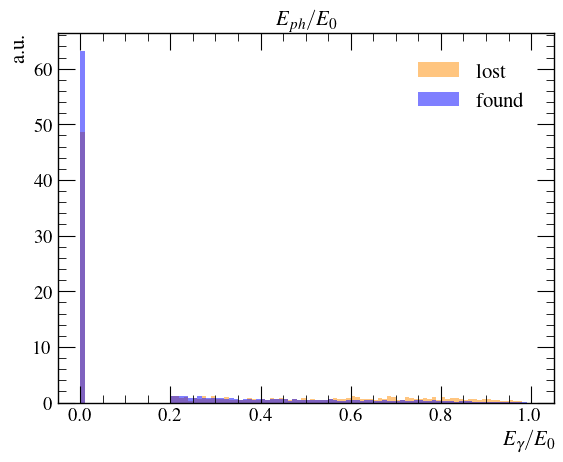

In [180]:
xlim=0

plt.hist(
    Z_lost,
    bins=100,
    density=True,
    alpha=0.5,
    histtype="bar",
    color="darkorange",
    label="lost",
    range=[xlim,1]
)
plt.hist(
    Z_found,
    bins=100,
    density=True,
    alpha=0.5,
    histtype="bar",
    color="blue",
    label="found",
    range=[xlim,1]
)
plt.xlabel(r"$E_\gamma/E_0$")
plt.ylabel("a.u.")
plt.title(r"$E_{ph}/E_0$")
plt.legend()
plt.show()

In [181]:
tuple_found = ntuple[~ntuple.lost]
tuple_lost = ntuple[ntuple.lost]

brem_x_found = ak.to_numpy(ak.flatten(tuple_found["brem_vtx_x"]))
brem_z_found = ak.to_numpy(ak.flatten(tuple_found["brem_vtx_z"]))

brem_x_lost = ak.to_numpy(ak.flatten(tuple_lost["brem_vtx_x"]))
brem_z_lost = ak.to_numpy(ak.flatten(tuple_lost["brem_vtx_z"]))

n_found = len(brem_x_found)
n_lost = len(brem_x_lost)
print("found: ", n_found, ", lost: ", n_lost)
stretch_factor = n_lost / n_found
print(stretch_factor)
ak.flatten(tuple_found["brem_vtx_x"])

found:  4943 , lost:  1757
0.3554521545620069


<Array [-26.5, 19.5, 34.7, 36.4, ..., 31.5, -67.7, 25] type='4943 * float64'>

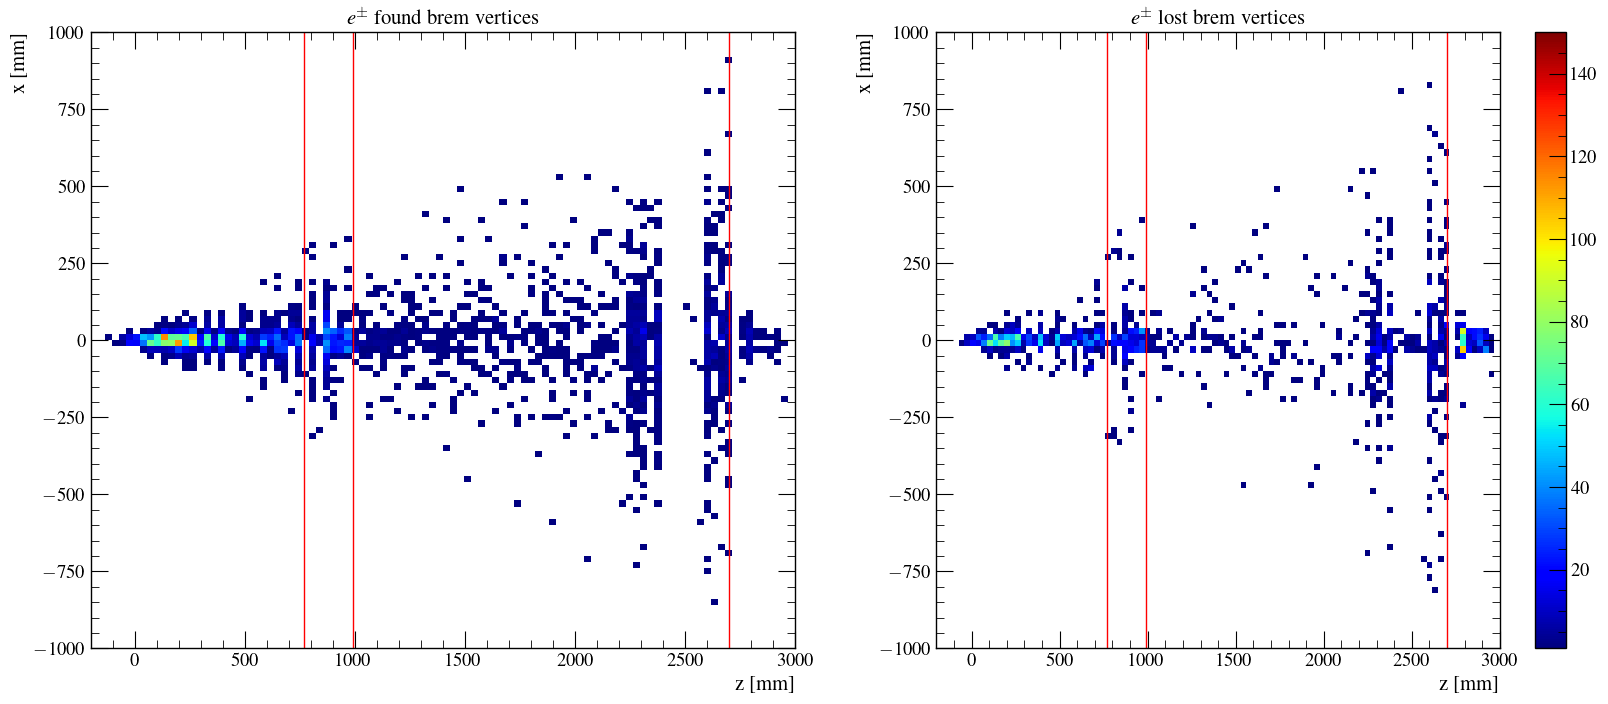

In [182]:
vmax = 150
nbins = 100

fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

a0 = ax0.hist2d(
    brem_z_found,
    brem_x_found,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax,
    range=[[-200, 3000], [-1000, 1000]],
)
ax0.vlines([770, 990, 2700], -1000, 1000,colors="red")
ax0.set_ylim(-1000, 1000)
ax0.set_xlim(-200, 3000)
ax0.set_xlabel("z [mm]")
ax0.set_ylabel("x [mm]")
ax0.set_title(r"$e^\pm$ found brem vertices")

a1 = ax1.hist2d(
    brem_z_lost,
    brem_x_lost,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax * stretch_factor,
    range=[[-200, 3000], [-1000, 1000]],
)
ax1.vlines([770, 990, 2700], -1000, 1000, colors="red")
ax1.set_ylim(-1000, 1000)
ax1.set_xlim(-200, 3000)
ax1.set_xlabel("z [mm]")
ax1.set_ylabel("x [mm]")
ax1.set_title(r"$e^\pm$ lost brem vertices")
# ax1.set(xlim=(0,4000), ylim=(-1000,1000))

plt.colorbar(a0[3], ax=ax1)

plt.show()

In [183]:
energy_emissions = ak.ArrayBuilder()

for jelec in range(ak.num(ntuple, axis=0)):
    energy_emissions.begin_record()
    energy_emissions.field("lost").boolean(ntuple[jelec, "lost"])
    energy_emissions.field("energy").real(ntuple[jelec, "energy"])

    tmp_velo = 0
    tmp_richut = 0
    tmp_neither = 0
    tmp_velo_length = 0
    tmp_richut_length = 0
    tmp_neither_length = 0
    
    for jphoton in range(ak.num(ntuple[jelec]["brem_photons_pe"], axis=0)):
        if ntuple[jelec, "brem_vtx_z", jphoton] <= 770:
            tmp_velo += ntuple[jelec, "brem_photons_pe", jphoton]
            tmp_velo_length += 1
        elif (ntuple[jelec, "brem_vtx_z", jphoton] > 770) and (
            ntuple[jelec, "brem_vtx_z", jphoton] <= 2700
        ):
            tmp_richut += ntuple[jelec, "brem_photons_pe", jphoton]
            tmp_richut_length += 1
        else:
            tmp_neither += ntuple[jelec, "brem_photons_pe", jphoton]
            tmp_neither_length += 1

    energy_emissions.field("velo_length").integer(tmp_velo_length)
    energy_emissions.field("velo").real(tmp_velo)

    energy_emissions.field("rich_length").integer(tmp_richut_length)
    energy_emissions.field("rich").real(tmp_richut)
    
    energy_emissions.field("neither_length").integer(tmp_neither_length)
    energy_emissions.field("downstream").real(tmp_neither)
    
    energy_emissions.field("photon_length").integer(tmp_neither_length+tmp_richut_length+tmp_velo_length)
    
    if (tmp_velo==0) and (tmp_richut==0):
        energy_emissions.field("quality").integer(0)
    else:
        energy_emissions.field("quality").integer(1)

    energy_emissions.end_record()

energy_emissions = ak.Array(energy_emissions)

print(ak.num(energy_emissions,axis=0))


13313


In [184]:
energy_emissions[3]

<Record {lost: False, energy: 9.36e+03, ...} type='{lost: bool, energy: flo...'>

In [185]:
# efficiency berechnen als found in velo oder rich über alle elektronen
# dann kann man zusammenrechnen mit velo, rich, und allen anderen elektronen
# expected eff  = 81.19%

electrons_found = energy_emissions[~energy_emissions.lost]
electrons_lost = energy_emissions[energy_emissions.lost]

anz_found = ak.num(electrons[~electrons.lost],axis=0)
anz_lost = ak.num(electrons[electrons.lost],axis=0)
print("found: ",anz_found)
print("lost: ", anz_lost)

num_velo_found = 0
num_rich_found = 0
num_no_up_rad_found = 0
for itr in range(ak.num(electrons_found, axis=0)):
    if (electrons_found[itr, "quality"]==1):
        if (electrons_found[itr, "velo"] >= electrons_found[itr, "rich"]):
            num_velo_found += 1
        else:
            num_rich_found += 1
    else:
        num_no_up_rad_found += 1

num_velo_lost = 0
num_rich_lost = 0
num_no_up_rad_lost = 0
for itr in range(ak.num(electrons_lost, axis=0)):
    if (electrons_lost[itr, "quality"]==1):
        if (electrons_lost[itr, "velo"] >= electrons_lost[itr, "rich"]):
            num_velo_lost += 1
        else:
            num_rich_lost += 1
    else:
        num_no_up_rad_lost += 1



denom = ak.num(electrons,axis=0)
print(denom)


eff_velo = num_velo_found/denom

eff_rich = num_rich_found/denom

eff_other = ak.num(electrons_found[electrons_found.quality==0],axis=0)/denom

print("VELO energy emission, eff: ", eff_velo)

print("RICH1+UT energy emission, eff: ", eff_rich)

print("Neither, eff: ", eff_other)

print("total efficiency: ", eff_velo + eff_rich + eff_other)

print("efficiency: ", anz_found/(anz_found+anz_lost))

print("\nfound in velo/(found + lost in velo)")

eff_velo = num_velo_found/(num_velo_found+num_velo_lost)
eff_rich = num_rich_found/(num_rich_found+num_rich_lost)

eff_no_rad = num_no_up_rad_found/(num_no_up_rad_found+num_no_up_rad_lost)

print("VELO energy emission, eff: ", eff_velo)

print("RICH1+UT energy emission, eff: ", eff_rich)

print("eff von e die nicht strahlen: ", eff_no_rad )

found:  10923
lost:  2390
13313
VELO energy emission, eff:  0.1835048448884549
RICH1+UT energy emission, eff:  0.1139487718771126
Neither, eff:  0.5230226094794562
total efficiency:  0.8204762262450237
efficiency:  0.8204762262450237

found in velo/(found + lost in velo)
VELO energy emission, eff:  0.8151484818151484
RICH1+UT energy emission, eff:  0.737481769567331
eff von e die nicht strahlen:  0.8430802760624773


In [186]:
print(ak.num(electrons[~electrons.lost],axis=0))
print(ak.num(electrons[electrons.lost],axis=0))
print(ak.num(electrons,axis=0))



10923
2390
13313


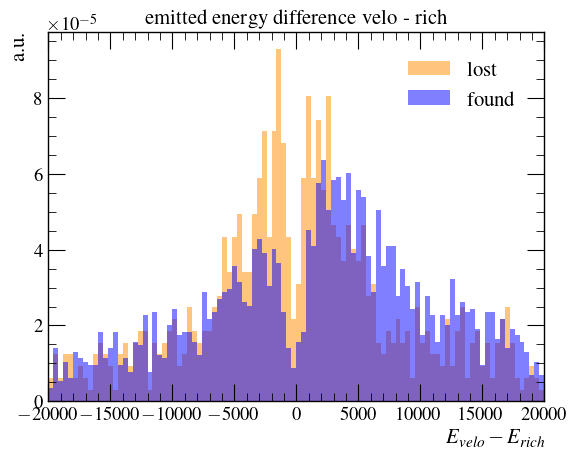

In [187]:
# energyspektren angucken von velo und rich
diff_found = ak.to_numpy(energy_emissions[(~energy_emissions.lost) & (energy_emissions.quality==1)]["velo"]) - ak.to_numpy(energy_emissions[(~energy_emissions.lost) & (energy_emissions.quality==1)]["rich"])
diff_lost = ak.to_numpy(energy_emissions[(energy_emissions.lost) & (energy_emissions.quality==1)]["velo"]) - ak.to_numpy(energy_emissions[(energy_emissions.lost) & (energy_emissions.quality==1)]["rich"])

xlim = 20000

plt.hist(diff_lost,bins=100,density=True,alpha=0.5,histtype="bar",color="darkorange",label="lost",range=[-xlim,xlim])
plt.hist(diff_found,bins=100,density=True,alpha=0.5,histtype="bar",color="blue",label="found", range=[-xlim,xlim])
plt.xlim(-20000,20000)
plt.title("emitted energy difference velo - rich")
plt.xlabel(r"$E_{velo} - E_{rich}$")
plt.ylabel("a.u.")
plt.legend()
plt.show()

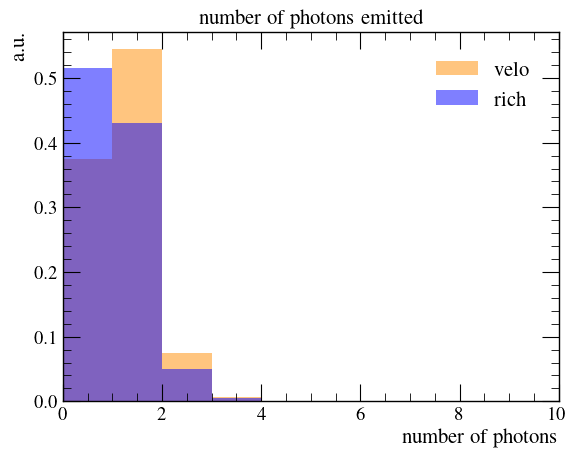

In [188]:
# number of brem vtx with E>x*E_0

number_velo = ak.to_numpy(energy_emissions[energy_emissions.quality==1]["velo_length"])
number_rich = ak.to_numpy(energy_emissions[energy_emissions.quality==1]["rich_length"])


plt.hist(number_velo,bins=10,density=True,alpha=0.5,histtype="bar",color="darkorange",label="velo",range=[0,10])
plt.hist(number_rich,bins=10,density=True,alpha=0.5,histtype="bar",color="blue",label="rich",range=[0,10])
plt.xlim(0,10)
plt.title("number of photons emitted")
plt.xlabel("number of photons")
plt.ylabel("a.u.")
plt.legend()
plt.show()

In [189]:
""" 
photon cut = x*E_0
effs, all photons included: x=0
found in velo/(found + lost in velo)
VELO energy emission, eff:  0.8446167611094543
RICH1+UT energy emission, eff:  0.7961586121437423
eff von e die nicht strahlen:  0.7954674220963173
"""

' \nphoton cut = x*E_0\neffs, all photons included: x=0\nfound in velo/(found + lost in velo)\nVELO energy emission, eff:  0.8446167611094543\nRICH1+UT energy emission, eff:  0.7961586121437423\neff von e die nicht strahlen:  0.7954674220963173\n'